# Neural Network

## Import Necessary Packages

In [73]:
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import os
import optuna
from sklearn.metrics import f1_score
import torch.cuda

In [74]:
# set deterministic behaviour so tuning experiments are reproducible
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data Preprocessing

In [75]:
# read in cleaned merged data
df = pd.read_csv("../data/clean_merged.csv")
print(df.head())
print(df.columns)

        id  code_gender  flag_own_car  flag_own_realty  cnt_children  \
0  5008804            1             1                1             0   
1  5008805            1             1                1             0   
2  5008806            1             1                1             0   
3  5008808            0             0                1             0   
4  5008809            0             0                1             0   

   amt_income_total      name_income_type            name_education_type  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     name_family_status  name_housing_type  ...  cnt_fam_members  age  \
0        Civil marriage   Rented apar

In [76]:
# remove columns that are not relevant for prediction
# leaky features that would not be available at prediction time
leaky_features = ['max_delay', 'avg_delay', 'num_bad_months', 'months_total']
# labels and ids would not be useful for prediction
X = df.drop(columns=['label', 'id', 'amt_income_total'] + leaky_features)
y = df['label'].astype('int')

# Extra feature engineering: 
# create interaction features
# Handle potential division by zero, although cnt_fam_members >= 1 in this dataset
# Add a small epsilon to avoid NaNs if cnt_fam_members could be 0
epsilon = 1e-6 
X['income_per_member'] = X['amt_income_log'] / (X['cnt_fam_members'] + epsilon)
X['age_x_employment'] = X['age'] * X['years_employed']
X['children_ratio'] = X['cnt_children'] / (X['cnt_fam_members'] + epsilon)

# Get the updated list of numerical columns for scaling
numerical_cols = [
    'age', 'years_employed', 'amt_income_log', 'cnt_children', 'cnt_fam_members',
    'income_per_member', 'age_x_employment', 'children_ratio'
]

# Update the categorical_cols list to exclude the new numeric features
categorical_cols = [
    'code_gender',
    'name_income_type',
    'name_education_type',
    'name_family_status',
    'name_housing_type',
    'occupation_type',
    'flag_own_car', 
    'flag_own_realty',
    'flag_mobil',
    'flag_work_phone', 
    'flag_phone', 
    'flag_email',
    'is_employed'
]

In [77]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
else:
    X_encoded = X

X_encoded.head()
X_encoded.columns

Index(['code_gender', 'flag_own_car', 'flag_own_realty', 'cnt_children',
       'flag_mobil', 'flag_work_phone', 'flag_phone', 'flag_email',
       'cnt_fam_members', 'age', 'is_employed', 'years_employed',
       'amt_income_log', 'income_per_member', 'age_x_employment',
       'children_ratio', 'name_income_type_Pensioner',
       'name_income_type_State servant', 'name_income_type_Student',
       'name_income_type_Working', 'name_education_type_Higher education',
       'name_education_type_Incomplete higher',
       'name_education_type_Lower secondary',
       'name_education_type_Secondary / secondary special',
       'name_family_status_Married', 'name_family_status_Separated',
       'name_family_status_Single / not married', 'name_family_status_Widow',
       'name_housing_type_House / apartment',
       'name_housing_type_Municipal apartment',
       'name_housing_type_Office apartment',
       'name_housing_type_Rented apartment', 'name_housing_type_With parents',
       'o

In [78]:
# split once for train/validation/test so evaluation stays unbiased

# split into train (72%), val (8%), test (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=SEED,
    stratify=y,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.1,
    random_state=SEED,
    stratify=y_train_full,
)

scaler = MinMaxScaler()
# min-max scale on train set, apply to val and test sets
X_train_scaled = scaler.fit_transform(X_train[numerical_cols])
X_val_scaled = scaler.transform(X_val[numerical_cols])
X_test_scaled = scaler.transform(X_test[numerical_cols])

# check class distribution in each split
train_class_counts = Counter(y_train)
val_class_counts = Counter(y_val)
test_class_counts = Counter(y_test)

train_class_counts, val_class_counts, test_class_counts


(Counter({0: 25804, 1: 444}),
 Counter({0: 2868, 1: 49}),
 Counter({0: 7169, 1: 123}))

In [79]:
# balance only the training fold; keep validation/test untouched
smote = SMOTE(random_state=SEED)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("Original training distribution:", train_class_counts)
print("Balanced training distribution:", Counter(y_train_balanced))

Original training distribution: Counter({0: 25804, 1: 444})
Balanced training distribution: Counter({0: 25804, 1: 25804})


In [80]:
# compute pos_weight for BCEWithLogitsLoss
pos_weight_value = train_class_counts[0] / train_class_counts[1]
pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32, device=device)
print(f"Calculated pos_weight: {pos_weight_value:.2f}")

Calculated pos_weight: 58.12


In [81]:
# build tensors and loaders; batches move to GPU/CPU device inside the loop
X_train_tensor = torch.tensor(X_train_balanced, dtype=torch.float32)
y_train_tensor = torch.tensor(np.array(y_train_balanced).reshape(-1, 1), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.to_numpy().reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy().reshape(-1, 1), dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


## Neural Network Baseline

In [82]:
# three-layer MLP that emits logits; dropout helps regularise high-dimensional features
class NN(nn.Module):
    # Rename 'hidden_layers' to 'num_neurons' for consistency
    def __init__(self, input_dim, num_neurons=128, dropout_rate=0.2):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, num_neurons) # Use num_neurons
        self.bn1 = nn.BatchNorm1d(num_neurons) 
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(dropout_rate)

        self.layer2 = nn.Linear(num_neurons, num_neurons) # Use num_neurons
        self.bn2 = nn.BatchNorm1d(num_neurons)
        self.act2 = nn.ReLU()
        self.drop2 = nn.Dropout(dropout_rate)

        self.layer3 = nn.Linear(num_neurons, num_neurons) # Use num_neurons
        self.bn3 = nn.BatchNorm1d(num_neurons)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(dropout_rate)

        self.output = nn.Linear(num_neurons, 1) # Use num_neurons

    def forward(self, x):
        x = self.drop1(self.act1(self.bn1(self.layer1(x))))
        x = self.drop2(self.act2(self.bn2(self.layer2(x))))
        x = self.drop3(self.act3(self.bn3(self.layer3(x))))
        x = self.output(x)
        return x

### Neural Network Baseline Training and Evaluation

In [83]:
input_dim = X_train_tensor.shape[1]  # get number of features after encoding
nn_base_model = NN(input_dim).to(device)

# weighted loss + regularisation to reflect true imbalance and stabilise training
criterion = nn.BCEWithLogitsLoss() # Use SMOTE only, so no pos_weight needed
optimizer = optim.Adam(nn_base_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

epochs = 80
patience = 10
train_losses = []
val_losses = []
val_accuracies = []
val_aucs = []
best_val_loss = float("inf")
early_stop_counter = 0
best_state_dict = copy.deepcopy(nn_base_model.state_dict())


In [84]:
for epoch in range(epochs):
    nn_base_model.train()
    epoch_loss = 0.0

    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        optimizer.zero_grad()
        logits = nn_base_model(X_batch)
        loss = criterion(logits, Y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(nn_base_model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    nn_base_model.eval()
    val_loss = 0.0
    val_logits = []
    val_targets = []

    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            logits = nn_base_model(X_batch)
            loss = criterion(logits, Y_batch)

            val_loss += loss.item()
            val_logits.append(logits.cpu())
            val_targets.append(Y_batch.cpu())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    logits_tensor = torch.cat(val_logits).squeeze()
    targets_tensor = torch.cat(val_targets).squeeze()
    probs = torch.sigmoid(logits_tensor)
    preds = (probs >= 0.5).float()
    val_accuracy = (preds == targets_tensor).float().mean().item()
    val_accuracies.append(val_accuracy)

    try:
        val_auc = roc_auc_score(targets_tensor.numpy(), probs.numpy())
    except ValueError:
        val_auc = float("nan")
    val_aucs.append(val_auc)

    print(
        f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}"
    )

    if avg_val_loss < best_val_loss - 1e-4:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        best_state_dict = copy.deepcopy(nn_base_model.state_dict())
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

nn_base_model.load_state_dict(best_state_dict)


Epoch 1/80, Train Loss: 0.6588, Val Loss: 0.7009, Val Acc: 0.4895, Val AUC: 0.6041
Epoch 2/80, Train Loss: 0.6270, Val Loss: 0.6678, Val Acc: 0.5382, Val AUC: 0.6383
Epoch 3/80, Train Loss: 0.6032, Val Loss: 0.6343, Val Acc: 0.5770, Val AUC: 0.6561
Epoch 4/80, Train Loss: 0.5875, Val Loss: 0.5854, Val Acc: 0.6373, Val AUC: 0.6649
Epoch 5/80, Train Loss: 0.5770, Val Loss: 0.6511, Val Acc: 0.5759, Val AUC: 0.6800
Epoch 6/80, Train Loss: 0.5660, Val Loss: 0.5677, Val Acc: 0.6483, Val AUC: 0.6772
Epoch 7/80, Train Loss: 0.5570, Val Loss: 0.5641, Val Acc: 0.6565, Val AUC: 0.6667
Epoch 8/80, Train Loss: 0.5485, Val Loss: 0.5591, Val Acc: 0.6688, Val AUC: 0.6704
Epoch 9/80, Train Loss: 0.5356, Val Loss: 0.5457, Val Acc: 0.6908, Val AUC: 0.6706
Epoch 10/80, Train Loss: 0.5286, Val Loss: 0.5169, Val Acc: 0.7196, Val AUC: 0.7078
Epoch 11/80, Train Loss: 0.5262, Val Loss: 0.5482, Val Acc: 0.6846, Val AUC: 0.7156
Epoch 12/80, Train Loss: 0.5151, Val Loss: 0.5070, Val Acc: 0.7316, Val AUC: 0.7023
E

<All keys matched successfully>

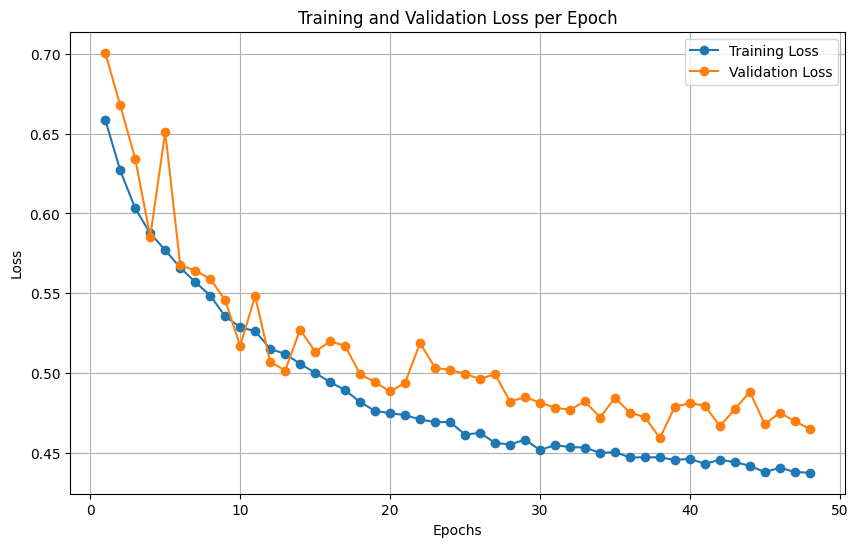

In [85]:
num_epochs_run = len(train_losses)
plt.figure(figsize=(10, 6))

plt.plot(range(1, num_epochs_run + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs_run + 1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()


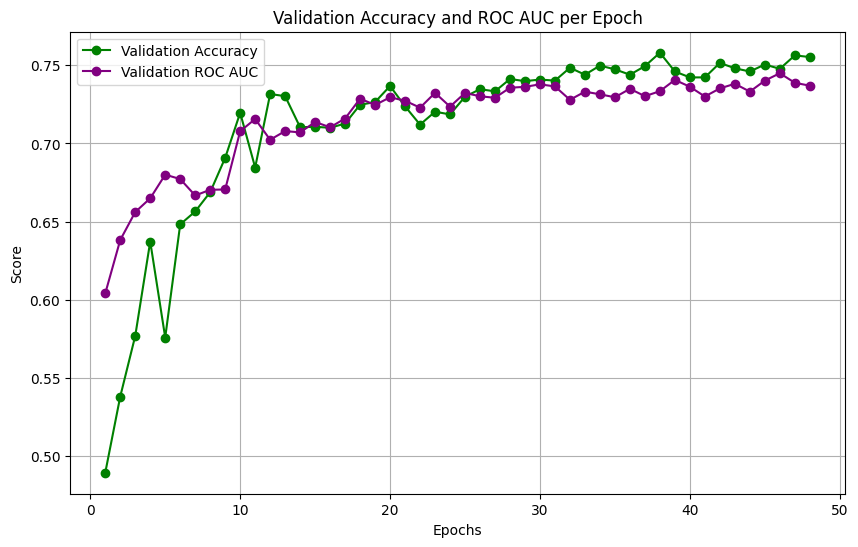

In [86]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs_run + 1), val_accuracies, marker='o', label='Validation Accuracy', color='green')
plt.plot(range(1, num_epochs_run + 1), val_aucs, marker='o', label='Validation ROC AUC', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Validation Accuracy and ROC AUC per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [87]:
# evaluate on the untouched test set using probabilities for calibrated metrics
nn_base_model.eval()
test_logits = []
test_targets = []

with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        logits = nn_base_model(X_batch)
        test_logits.append(logits.cpu())
        test_targets.append(Y_batch.cpu())

test_logits = torch.cat(test_logits).squeeze()
test_targets = torch.cat(test_targets).squeeze()

test_probs = torch.sigmoid(test_logits).numpy()
test_preds = (test_probs >= 0.5).astype(int)
test_targets_np = test_targets.numpy().astype(int)

print("Classification Report:")
print(classification_report(test_targets_np, test_preds))
print("Confusion Matrix:")
print(confusion_matrix(test_targets_np, test_preds))
try:
    print("ROC AUC Score:", roc_auc_score(test_targets_np, test_probs))
except ValueError:
    print("ROC AUC Score: NaN (only one class present)")


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      7169
           1       0.03      0.52      0.06       123

    accuracy                           0.74      7292
   macro avg       0.51      0.63      0.46      7292
weighted avg       0.97      0.74      0.84      7292

Confusion Matrix:
[[5362 1807]
 [  59   64]]
ROC AUC Score: 0.6868291322053965


## Neural Network Hypertune

In [88]:
class NN_Tune(nn.Module):
    def __init__(self, input_size, num_layers, num_neurons, dropout_rate):
        super().__init__()
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_size, num_neurons))
        layers.append(nn.BatchNorm1d(num_neurons))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        # Hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(num_neurons, num_neurons))
            layers.append(nn.BatchNorm1d(num_neurons))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        
        # Output layer 
        layers.append(nn.Linear(num_neurons, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [89]:
def objective(trial):
    num_layers = trial.suggest_int("num_layers", 2, 5)
    num_neurons = trial.suggest_int("num_neurons", 32, 256, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True) # Add weight_decay
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd"])
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256]) # Add 128

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    model = NN_Tune(
        input_size=X_train_tensor.shape[1],
        num_layers=num_layers,
        num_neurons=num_neurons,
        dropout_rate=dropout_rate
    ).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    if optimizer_name == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) # Add weight_decay
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    max_val_auc = 0.0 

    for epoch in range(100):
        model.train()
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, Y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        val_logits_list = []
        val_targets_list = []
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                logits = model(X_batch)
                val_logits_list.append(logits.cpu())
                val_targets_list.append(Y_batch.cpu())
        
        logits_tensor = torch.cat(val_logits_list).squeeze()
        targets_tensor = torch.cat(val_targets_list).squeeze()
        probs = torch.sigmoid(logits_tensor)
        
        try:
            val_auc = roc_auc_score(targets_tensor.numpy(), probs.numpy())
        except ValueError:
            val_auc = 0.5
        
        if val_auc > max_val_auc:
            max_val_auc = val_auc

        trial.report(val_auc, epoch)

        # Early stopping
        if trial.should_prune():
            torch.cuda.empty_cache() 
            raise optuna.exceptions.TrialPruned()

    torch.cuda.empty_cache()
    return max_val_auc

In [90]:
print("\nStarting Hyperparameter Tuning")

#max AUC
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50) 

#save best trial and best config
best_trial = study.best_trial
best_config = best_trial.params

print(f"Best trial final validation AUC: {best_trial.value:.4f}")
print(f"Best trial config: {best_config}")

[I 2025-11-16 21:44:04,433] A new study created in memory with name: no-name-d424d483-4a24-498c-9f91-a6c625c12270



Starting Hyperparameter Tuning


[I 2025-11-16 21:45:39,558] Trial 0 finished with value: 0.7214015313238266 and parameters: {'num_layers': 4, 'num_neurons': 83, 'dropout_rate': 0.10535171298857766, 'lr': 0.0005314277608064569, 'weight_decay': 9.42432726706201e-05, 'optimizer': 'sgd', 'batch_size': 128}. Best is trial 0 with value: 0.7214015313238266.
[I 2025-11-16 21:47:31,940] Trial 1 finished with value: 0.7307801781800586 and parameters: {'num_layers': 4, 'num_neurons': 197, 'dropout_rate': 0.24089460569748913, 'lr': 0.0001961344224339719, 'weight_decay': 4.5262021929182125e-05, 'optimizer': 'adam', 'batch_size': 128}. Best is trial 1 with value: 0.7307801781800586.
[I 2025-11-16 21:48:20,631] Trial 2 finished with value: 0.5993866165713146 and parameters: {'num_layers': 2, 'num_neurons': 56, 'dropout_rate': 0.2224811515666013, 'lr': 0.0003960702837109973, 'weight_decay': 4.740384059342726e-06, 'optimizer': 'sgd', 'batch_size': 256}. Best is trial 1 with value: 0.7307801781800586.
[I 2025-11-16 21:49:38,069] Trial

Best trial final validation AUC: 0.7618
Best trial config: {'num_layers': 5, 'num_neurons': 250, 'dropout_rate': 0.194001407576281, 'lr': 0.0016764025677080947, 'weight_decay': 2.303324531161001e-05, 'optimizer': 'adam', 'batch_size': 128}


In [92]:
print("\nTraining Best Model")

best_model = NN_Tune(
    input_size=X_train_tensor.shape[1],
    num_layers=best_config["num_layers"],
    num_neurons=best_config["num_neurons"],
    dropout_rate=best_config["dropout_rate"]
).to(device)

#create loaders with the best batch size
train_loader_best = DataLoader(train_dataset, batch_size=best_config["batch_size"], shuffle=True)
val_loader_best = DataLoader(val_dataset, batch_size=best_config["batch_size"])

#use best optimizer and lr
if best_config["optimizer"] == "adam":
    optimizer = optim.Adam(best_model.parameters(), lr=best_config["lr"], weight_decay=1e-4)
else:
    optimizer = optim.SGD(best_model.parameters(), lr=best_config["lr"], momentum=0.9)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3) 

epochs = 80
patience = 10
best_val_auc = float("-inf") 
early_stop_counter = 0
best_state_dict = copy.deepcopy(best_model.state_dict())

for epoch in range(epochs):
    train_loss_total = 0.0
    best_model.train() #train
    for X_batch, Y_batch in train_loader_best:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        logits = best_model(X_batch)
        loss = criterion(logits, Y_batch)
        loss.backward()
        optimizer.step()
        train_loss_total += loss.item()
    avg_train_loss = train_loss_total / len(train_loader_best)

    val_loss_total = 0.0
    val_logits = []
    val_targets = []
    best_model.eval() #evaluate
    with torch.no_grad():
        for X_batch, Y_batch in val_loader_best:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            logits = best_model(X_batch)
            loss = criterion(logits, Y_batch)
            val_loss_total += loss.item()
            val_logits.append(logits.cpu())
            val_targets.append(Y_batch.cpu())
    avg_val_loss = val_loss_total / len(val_loader_best)

    logits_tensor = torch.cat(val_logits).squeeze()
    targets_tensor = torch.cat(val_targets).squeeze()
    probs = torch.sigmoid(logits_tensor)
    val_accuracy = (probs.round() == targets_tensor).float().mean().item()

    try:
        val_auc = roc_auc_score(targets_tensor.numpy(), probs.numpy())
    except ValueError:
        val_auc = 0.5

    scheduler.step(val_auc)
    
    print(
        f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}"
    )

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        early_stop_counter = 0
        best_state_dict = copy.deepcopy(best_model.state_dict())
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

best_model.load_state_dict(best_state_dict)


Training Best Model
Epoch 1/80, Train Loss: 2.8630, Val Loss: 3.6850, Val Acc: 0.0288, Val AUC: 0.6199
Epoch 2/80, Train Loss: 2.3271, Val Loss: 3.6809, Val Acc: 0.0435, Val AUC: 0.6632
Epoch 3/80, Train Loss: 2.2721, Val Loss: 3.7271, Val Acc: 0.0477, Val AUC: 0.6181
Epoch 4/80, Train Loss: 2.2277, Val Loss: 3.3654, Val Acc: 0.0902, Val AUC: 0.6586
Epoch 5/80, Train Loss: 2.1930, Val Loss: 3.5771, Val Acc: 0.0888, Val AUC: 0.6465
Epoch 6/80, Train Loss: 2.1603, Val Loss: 3.4287, Val Acc: 0.1344, Val AUC: 0.6789
Epoch 7/80, Train Loss: 2.1392, Val Loss: 3.3482, Val Acc: 0.1244, Val AUC: 0.6763
Epoch 8/80, Train Loss: 2.1020, Val Loss: 3.3697, Val Acc: 0.1323, Val AUC: 0.6945
Epoch 9/80, Train Loss: 2.0900, Val Loss: 3.3234, Val Acc: 0.1460, Val AUC: 0.7086
Epoch 10/80, Train Loss: 2.0559, Val Loss: 3.3153, Val Acc: 0.1279, Val AUC: 0.6848
Epoch 11/80, Train Loss: 2.0253, Val Loss: 3.2283, Val Acc: 0.1567, Val AUC: 0.6673
Epoch 12/80, Train Loss: 2.0408, Val Loss: 3.4347, Val Acc: 0.14

<All keys matched successfully>

In [93]:
test_loader_final = DataLoader(test_dataset, batch_size=best_config["batch_size"])
best_model.eval()
test_logits = []
test_targets = []

with torch.no_grad():
    for X_batch, Y_batch in test_loader_final:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        logits = best_model(X_batch)
        test_logits.append(logits.cpu())
        test_targets.append(Y_batch.cpu())

test_logits = torch.cat(test_logits).squeeze()
test_targets = torch.cat(test_targets).squeeze()

test_probs = torch.sigmoid(test_logits).numpy()
test_preds = (test_probs >= 0.5).astype(int)
test_targets_np = test_targets.numpy().astype(int)

print("Classification Report (Threshold = 0.5):")
print(classification_report(test_targets_np, test_preds))
print("Confusion Matrix:")
print(confusion_matrix(test_targets_np, test_preds))
print("ROC AUC Score:", roc_auc_score(test_targets_np, test_probs))

Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

           0       0.99      0.31      0.47      7169
           1       0.02      0.88      0.04       123

    accuracy                           0.32      7292
   macro avg       0.51      0.59      0.26      7292
weighted avg       0.98      0.32      0.46      7292

Confusion Matrix:
[[2219 4950]
 [  15  108]]
ROC AUC Score: 0.6980427246035608


### Get optimal threshold for further tuning

In [94]:
val_loader_final = DataLoader(val_dataset, batch_size=best_config["batch_size"])
val_logits = []
val_targets = []
with torch.no_grad():
    for X_batch, Y_batch in val_loader_final:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        logits = best_model(X_batch)
        val_logits.append(logits.cpu())
        val_targets.append(Y_batch.cpu())

val_logits = torch.cat(val_logits).squeeze()
val_targets = torch.cat(val_targets).squeeze()
val_probs = torch.sigmoid(val_logits).numpy()
val_true = val_targets.numpy().astype(int)

thresholds = np.linspace(0.05, 0.95, 100)
scores = []
for thr in thresholds:
    preds = (val_probs >= thr).astype(int)
    scores.append((thr, f1_score(val_true, preds, pos_label=1)))

best_thr, best_f1 = max(scores, key=lambda x: x[1])
print(f"Best threshold {best_thr:.4f} with F1-score {best_f1:.4f} on validation set")
test_preds_tuned = (test_probs >= best_thr).astype(int)
print(f"Classification Report (Threshold = {best_thr:.4f}):")
print(classification_report(test_targets_np, test_preds_tuned))
print("Confusion Matrix:")
print(confusion_matrix(test_targets_np, test_preds_tuned))
try:
    print("ROC AUC Score:", roc_auc_score(test_targets_np, test_probs))
except ValueError:
    print("ROC AUC Score: NaN (only one class present)")

Best threshold 0.9500 with F1-score 0.0538 on validation set
Classification Report (Threshold = 0.9500):
              precision    recall  f1-score   support

           0       0.99      0.53      0.69      7169
           1       0.03      0.75      0.05       123

    accuracy                           0.54      7292
   macro avg       0.51      0.64      0.37      7292
weighted avg       0.98      0.54      0.68      7292

Confusion Matrix:
[[3814 3355]
 [  31   92]]
ROC AUC Score: 0.6980427246035608
